# Example of filling in values in a submission

In this notebook, we create some data and fill it into a submission.  This will illustrate the basic functionality of the module. 

## Some utilities 

We define a number of utility functions that will help us generate or data.  In "real life" the data will often be read from some external source (CSV, ROOT, or similar, file) and then filled into the submission.  The next few functions are therefore only illustrative. 

A scaled, normal probability density function. 

In [1]:
def nm(y,a,sigma):
    '''Normal PDF'''
    from math import sqrt, pi, exp
    return a/(sqrt(2*pi)*sigma)*exp(-0.5*y**2/sigma**2)

A normalised normal probability density function. 

In [2]:
def fy(a,y):
    return nm(y,a,1)

This will calculate rapidity $y$ from pseudorapidity $\eta$ given the parameter $a=p_{\mathrm{T}}/m$ 

$$\eta=\frac{1}{2}\log\left[\frac{-\left((1+2a^2)t^2-2t\sqrt{a^2+1}\sqrt{a^2t^2+1}+1\right)}{t^2-1}\right]\quad,$$

where $t=\tanh(y)$.  

In [3]:
def y2eta(y,a):
    '''Calculate rapidity (y) from pseudorapidity (eta)
    given the parameter a=pT/m'''
    from math import tanh, sqrt, log 
    t = tanh(y)
    t = -((1+2*a**2)*t**2
          - 2*t*sqrt(a**2+1)*sqrt(a**2*t**2+1) + 1)/(t**2-1)
    return 0.5 * log(t)

In [4]:
def feta(fy,eta,a):
    ''''''
    from math import sqrt, cosh
    return fy / sqrt(1 + a**2 / cosh(eta))

The next function will return a symmetric uncertainy (normal distributed). 

In [5]:
def se(v,f=.05):
    '''Statistical uncertainty'''
    from math import fabs
    from random import gauss
    return fabs(gauss(f*v,f/2*v))

The next function will return an asymmetric uncertainty - typically systematic uncertainties.  Lower and upper are normal distributed. 

In [6]:
def ae(v,f=0.1):
    '''Asymmetric (systematic) uncertainty'''
    return -se(v,f), se(v,f)

## Create the submission 

We start by creating the submission 

In [7]:
from hepdata import Submission 

s = Submission()  #.id('inspire',123456).id('arxiv','bla') 

Then, we create a table in the submission. 

In [8]:
t, m  = s.table('d',
                sys='AU AU',
                sqrts=200, 
                var='YRAP', 
                obs=['DN/DYRAP', 'DN/DETARAP'], 
                parts=['PI+','PI-', 'K+', 'K-', 'P', 'PBAR'], 
                phrases='Rapidity Dependence',
                name='simple',
                loc='name', 
                both=True,
                same=False)

We retrieve the independent variables ($y$, and $\eta$)

In [9]:
yrap   = t.independent('YRAP')
etarap = t.independent('ETARAP')

Then, for each centrality, we create dependent variables ($\mathrm{d}N_{\mathrm{ch}}/\mathrm{d}y$ and $\mathrm{d}N_{\mathrm{ch}}/\mathrm{d}\eta$).  Note that we define two "common" (or correlated over $y$ and $\eta$, respectively) systematic uncertainties via qualifiers, using the convention that the name starts with `sys:`. 

In [10]:
cents  = [(0,10),(10,20),(20,40)]
dndy   = []
dndeta = []
for c in cents:
    dy = t.dependent('DN/DYRAP')\
          .qualifier('CENTRALITY',f'{c[0]}-{c[1]}','PCT')\
          .qualifier('sys:Centrality',(c[1]-c[0])/2,'PCT')\
          .qualifier('sys:Bla',(c[1]-c[0])/2,'PCT')
    de = t.dependent('DN/DETARAP')\
          .qualifier('CENTRALITY','{}-{}'.format(c[0],c[1]),'PCT')\
          .qualifier('sys:Centrality',(c[1]-c[0])/2,'PCT')\
          .qualifier('sys:Bla',(c[1]-c[0])/2,'PCT')
    dndy  .append(dy)
    dndeta.append(de)

## Fill in 

With the above utilities, we can fill in the submission.  We start by setting the random number seed so that we can reproduce the result. 

In [11]:
from random import seed
seed(123456)

We get the independent and dependent variales from the table. 

In [12]:
[yrap],  dndyrap   = t.select('YRAP',  'DN/DYRAP')
[etarap],dndetarap = t.select('ETARAP','DN/DETARAP')

Then, we create a temporary list that holds the centrality ranges. 

In [13]:
tmp   = [float(c) 
         for dndy in dndyrap
         for q in dndy.qualifiers('CENTRALITY')
         for c in q['value'].split('-')]
cents = [(l,h) for l,h in zip(tmp[::2],tmp[1::2])]

Next, we want to fill in the actual values into our independent and dependent table columns.  We have $y\in[-3,3]$ in steps of $0.2$, set $a=p_{\mathrm{T}}/m=2.5$, scalars $1000,800,$ and $400$.  Our intermediate lists `iy` and `ieta` initially contains zeros. 

In [14]:
ymin = -3
ymax = +3
dy   = .2
y    = ymin
ptm  = 2.5
a    = [1000, 800, 400]
iy   = [0] * len(cents)
ieta = [0] * len(cents)

We can now loop over $y$ and calculate $\eta$ from this via the function `y2eta`.  We set these values on the independent columns `yrap` and `etarap`.  

Then, for each defined centrality, we loop and calculate $\mathrm{d}N_{\mathrm{ch}}/dy$ via the function `fy`, and generate a symmetric and asymmetric uncertainty using `se` and `ae`.  We also calculate $\mathrm{d}N_{\mathrm{ch}}/d\eta$ from $\mathrm{d}N_{\mathrm{ch}}/dy$ using the function `feta` and again set uncertainties. 

Finally, we increment $y$. 

In [15]:
while y < ymax:
    xy   = y + dy/2
    xeta = y2eta(xy,ptm)
    deta = y2eta(y,ptm) - y2eta(y+dy,ptm)
    yrap  .value(y,y+dy)
    etarap.value(value=xeta)

    for ic,(aa,dndy,dndeta) in enumerate(zip(a, dndyrap, dndetarap)):
        yy = fy(aa,y+dy/2)
        dndy.value(yy)\
            .symerror(se(yy), label='stat')\
            .asymerror(*ae(yy),label='sys')
        iy[ic] += dy * yy
        
        yeta = feta(yy,xeta,ptm)
        dndeta.value(yeta)\
              .symerror(se(yeta),label='stat')\
              .asymerror(*ae(yeta),label='sys')\
              .symerror(se(yeta),label='more')
        ieta[ic] += deta * yeta
        
    y += dy

Let us round to 2 significant digits on the dependent variables, and 4 on the independent variables 

In [16]:
s.roundNsig(2,4);

## The submission 

Let us see the summary information of the submission.  We do that by evaluating the submission as the cell output. 

In [17]:
s

We can also get a visual of the table by simply evaluating the table. 

In [18]:
t

## Plotting 

First, we create a plotter object.

In [19]:
from hepdata.plot import Plotter
p = Plotter()

We create sub-plots to put it into.   We use the _magic_ `%%capture` to suppress outputing the figure at this point. 

In [20]:
%%capture
from matplotlib.pyplot import subplots
fig, ax = subplots(ncols=2,sharey=True,figsize=(12,10),
                   gridspec_kw={'wspace':0,'hspace':0})

We create a dictionary of keywords to pass to the plotting. 
We stack uncertainties using propagation 

In [21]:
from hepdata import Value
calc_kw = dict(calc=Value.stack,stack_calc=Value.linvar)

Now plot $\mathrm{d}N_{\mathrm{ch}}/\mathrm{d}y$ (note the use of `%%capture` to suppress drawing of in this cell).

In [22]:
%%capture
for dy in dndyrap:
    p.plotXY(yrap,
             dy,
             axes=ax[0],
             type='fill',
             error_alpha=.2,
             qualifiers='*',
             fmt='s',
             markersize=5,
             calc_kw=calc_kw,
             common_kw={'type':'bar'})
    
ax[0].legend()

And we plot $\mathrm{d}N_{\mathrm{ch}}/\mathrm{d}\eta$ (again, notice the use of `%%capture`).  

In [23]:
%%capture
for deta in dndetarap:
    params = p.emptyParams(deta, calc_kw=calc_kw)
    params['stat']['type'] = 'bar'
    params['more'].update(dict(type='line',linestyle='--'))
    params['sys'].update(dict(type='marker',markersize=5,alpha=.5))

    cparams = p.emptyCommonParams(deta)
    cparams['Centrality'].update(dict(type='fill',label='Whatever'))
    cparams['Bla'].update(dict(type='bar',linewidth=3))
    
    p.plotXY(etarap,deta,
             axes=ax[1],
             fmt='o',
             markerfacecolor='white',
             calc_kw=calc_kw,
             labelled=True,
             common_kw=dict(yloc='middle',type='fill',
                            params=list(cparams.values())),
             qualifiers=['NAME','CENTRALITY'],
             params=list(params.values()))
    
ax[1].legend()

Finally, we show the plot.

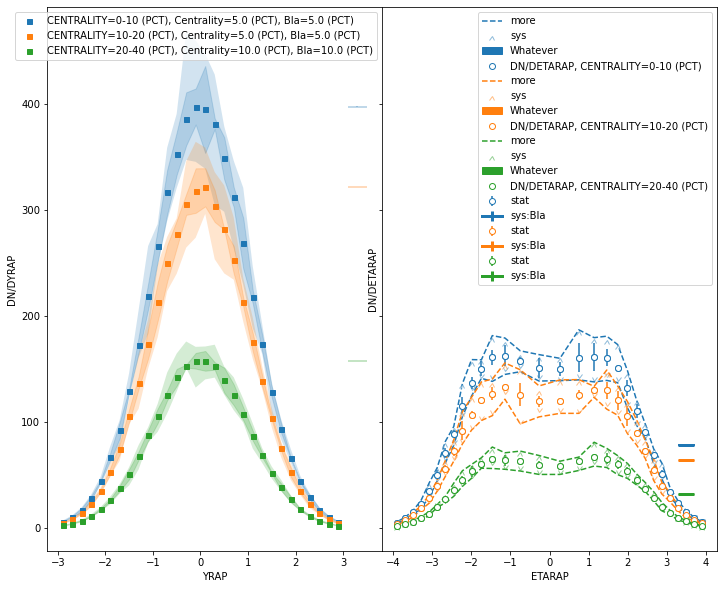

In [24]:
fig